In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
from tqdm import tqdm

## Load data

In [2]:
se_label = 'Individual Side Effect'

# Drug-Target
df_dt = pd.read_csv('../data/bio-decagon-targets.csv').rename(columns={'STITCH': 'drug', 'Gene': 'gene'})
df_dt = df_dt.rename(columns={'drug': 'STITCH'})

# Drug-Side Effect
df_ds = pd.read_csv('../data/bio-decagon-mono.csv') # drug - side-effect

# Drug ID mapper
df = pd.read_csv('../data/drugbank.txt', sep='\t')
df = df.drop_duplicates(subset=['DrugbankID', 'CID'], keep='first')

did_to_cid = {row.DrugbankID: row.CID for _, row in df[['DrugbankID', 'CID']].iterrows() if not pd.isnull(row.CID)}
cid_to_did = {row.CID: row.DrugbankID for _, row in df[['DrugbankID', 'CID']].iterrows() if not pd.isnull(row.CID)}

df_ds['compound'] = df_ds.STITCH.apply(lambda x: cid_to_did.get(x, None))
df_dt['compound'] = df_dt.STITCH.apply(lambda x: cid_to_did.get(x, None))

all_drugs = list(set(df_ds.STITCH.unique().tolist()).union(df_dt.STITCH.unique()))
all_targets = list(set(df_dt.gene.tolist()))
n_drugs = len(all_drugs)
n_targets = len(all_targets)
pp_idx_mapper = {p: all_targets.index(p) for p in all_targets}
all_se = list(df_ds[se_label].unique())
all_drugs_did = list(set(df_ds.compound.unique().tolist()).union(df_dt.compound.unique()))

se_idx_mapper = {se: i for i, se in enumerate(all_se)}
df_ds['se_idx'] = df_ds[se_label].apply(lambda x: se_idx_mapper[x])

# Drug Similarity
df_dsim = pd.read_csv('../data/similarity.csv', index_col=0)
df_dsim['STITCH0'] = df_dsim.compound0.apply(lambda x: did_to_cid.get(x, None))
df_dsim['STITCH1'] = df_dsim.compound1.apply(lambda x: did_to_cid.get(x, None))
print(df_ds.shape)

(174977, 5)


In [3]:
from typing import Set

def jaccard(s1: Set, s2: Set):
    return len(s1.intersection(s2))/len((s1.union(s2)))

jaccard({1,2,3,4}, {1,2})

0.5

In [4]:
df_dt.head()

,STITCH,gene,compound
0,CID000003488,1559,DB01016
1,CID000003488,8647,DB01016
2,CID000077992,3351,DB00998
3,CID000077992,3350,DB00998
4,CID000077992,3352,DB00998


In [5]:
df_ds.head()

,STITCH,Individual Side Effect,Side Effect Name,compound,se_idx
0,CID003062316,C1096328,central nervous system mass,DB01254,0
1,CID003062316,C0162830,Photosensitivity reaction,DB01254,1
2,CID003062316,C1611725,leukaemic infiltration brain,DB01254,2
3,CID003062316,C0541767,platelet adhesiveness abnormal,DB01254,3
4,CID003062316,C0242973,Ventricular dysfunction,DB01254,4


In [6]:
df_dsim.head()

,compound0,compound1,similarity,STITCH0,STITCH1
0,DB00153,DB00181,0.0678,CID000003249,CID000002284
1,DB00153,DB00184,0.1391,CID000003249,CID000000942
2,DB00153,DB00186,0.0863,CID000003249,CID000003958
3,DB00153,DB00188,0.1266,CID000003249,CID000093860
4,DB00153,DB00191,0.0545,CID000003249,CID000004771


In [7]:
from scipy.linalg import fractional_matrix_power
class DSERandomWalk:
    """Calculate similarity matrices and joint transition probability matrix
    df_ds (pd.DataFrame): drug and side-effects relationship dataframe
    df_dsim (pd.DataFrame): pre-calculated drug pairs similarity
    df_dt (pd.DataFrame): drug and protein targets relationship dataframe
    test_drug: selected drug to predict side effects (seed node)
    lmb (float): jumping probability from one network to another (drug <-> side-effects)
    w_d (float): drug chemical-structure similarity weight 
                 where 1-w_d will be drug-target similarity weight         
    """
    def __init__(self, df_ds, df_dsim, df_dt, test_drugs, known_se=0.2, lmd=0.5, w_d=0.7):
        self.known_se = known_se
        self.test_drugs = test_drugs
        self.lmd = lmd
        self.w_d = w_d
        self.df_ds = df_ds
        self.df_dsim = df_dsim
        self.df_dt = df_dt
        all_drugs = list(set(df_ds[df_ds.compound.notna()].STITCH.unique().tolist()).intersection(
    df_dt[df_dt.compound.notna()].STITCH.unique()))
        self.all_drugs = all_drugs
        self.n_drugs = len(all_drugs)
        all_se = list(df_ds[se_label].unique())
        self.all_se = all_se
        
        
        print('drug shared target similarity')
        S_d_t = self.dd_target_similarity_matrix(df_dt, all_drugs=all_drugs)
        print('drug chem similarity')
        S_d_c = self.dd_chem_similarity_matrix(all_drugs=all_drugs, df_sim=df_dsim)
        S_d = w_d*S_d_c + (1-w_d)*S_d_t


        print('ds adjacency matrix')
        A_ds = self.ds_adj_matrix(df_ds, all_se, all_drugs)
        # side effect similarity
        print('side effect similarity')
        S_s = self.ss_similarity_matrix(df=df_ds, all_se=all_se)
    
        print('Mss')
        self.M_ss = self.ss_transition_matrix(S_s, A_ds, lmd=lmd)
        print('M_sd')
        self.M_sd = self.sd_transition_matrix(df=df_ds, all_drugs=all_drugs, all_se=all_se, A=A_ds, lmd=lmd)
        print('Mds')
        self.M_ds = self.ds_transition_matrix(df=df_ds, all_drugs=all_drugs, all_se=all_se, A=A_ds, lmd=lmd)
        print('Mdd')
        self.M_dd = self.dd_transition_matrix(S_d, A_ds, lmd=lmd)
        
        self.Ms = np.concatenate([self.M_ss, self.M_sd], axis=1)
        self.Md = np.concatenate([self.M_ds, self.M_dd], axis=1)
        self.M = np.concatenate([self.Ms, self.Md], axis=0)
        self.p_mapping = np.concatenate([self.all_se, self.all_drugs])
    
    def ds_adj_matrix(self, df, all_se, all_drugs): 
        """Drug-Side Effect Adjacency Matrix"""
        n_drugs = len(all_drugs)
        n_se = len(all_se) 
        A = np.zeros((n_drugs, n_se), dtype=np.float32)
        adj_lst = []
        for i in tqdm(range(n_drugs)):
            if all_drugs[i] in self.test_drugs and self.known_se == 0:
                continue
            elif all_drugs[i] in self.test_drugs:
                nbrs = list(df[df.STITCH==all_drugs[i]][se_label].unique())
                allowed_nbrs = int(len(nbrs)*self.known_se)
                nbrs = nbrs[:allowed_nbrs]
            else:
                nbrs = list(df[df.STITCH==all_drugs[i]][se_label].unique())
                
            nbrs = [all_se.index(nb) for nb in nbrs]
            for j in nbrs:
                A[i, j] = 1
        return A   
    
    def dd_chem_similarity_matrix(cls, all_drugs, df_sim):
        """Drug-Drug similarity matrix based on chemical structures"""
        n = len(all_drugs)
        M = np.zeros((n, n), dtype=np.float32)
        adj_lst = []
        for i in tqdm(range(n-1)):
            d1 = all_drugs[i]
            poi = df_sim[(df_sim.STITCH0==d1)|(df_sim.STITCH1==d1)]
            if not poi.shape[0]:
                continue
            for j in range(i+1, n):
                d2 = all_drugs[j]
                ss = poi[(poi.STITCH0==d2)|(poi.STITCH1==d2)]
                if ss.shape[0]:
                    s = ss.iloc[0].similarity
                    M[i, j] = s
                    M[j, i] = s

        # normalize
        norm_terms = np.sum(M, axis=1)
        norm_terms[np.where(norm_terms == 0)] = 1
        D = np.diag(norm_terms)
        D_sq = fractional_matrix_power(D, -1/2)
        S = np.matmul(np.matmul(D_sq, M), D_sq)

        return S

    def dd_target_similarity_matrix(cls, df_dt, all_drugs):
        """Drug-Drug similarity based on shared targets"""
        n = len(all_drugs)
        M = np.zeros((n, n), dtype=np.float32)
        adj_lst = []
        for i in tqdm(range(n-1)):
            d1 = all_drugs[i]
            targets_i = set(df_dt[df_dt.STITCH==d1].gene)
            if not len(targets_i):
                continue
            for j in range(i+1, n):
                d2 = all_drugs[j]
                targets_j = set(df_dt[df_dt.STITCH==d2].gene)
                if not len(targets_i):
                    continue
                jc = jaccard(targets_i, targets_j)
                M[i, j] = jc
                M[j, i] = jc
        norm_terms = np.sum(M, axis=1)  
        norm_terms[np.where(norm_terms == 0)] = 1
        D = np.diag(norm_terms)
        D_sq = fractional_matrix_power(D, -1/2)
        S = np.matmul(np.matmul(D_sq, M), D_sq)
        return S

    def ss_similarity_matrix(self, df, all_se):
        """Side Effect-Side Effect similarity based on shared drugs"""
        n = len(all_se)
        M = np.zeros((n, n), dtype=np.float32)
        adj_lst = []
        A_ds = self.A_ds
        A_sd = A_ds.T
        for i in tqdm(range(n-1)):
            se1 = all_se[i]
            paired_drugs = A_sd[i]
            drugs_i = set(np.argwhere(paired_drugs==1)[:,0])

            if not len(drugs_i):
                continue
            for j in range(i+1, n):
                se2 = all_se[j]
                paired_drugs = A_sd[j]
                drugs_j = set(np.argwhere(paired_drugs==1)[:,0])

                if not len(drugs_i):
                    continue
                jc = jaccard(drugs_i, drugs_j)
                M[i, j] = jc
                M[j, i] = jc
        norm_terms = np.sum(M, axis=1)  
        norm_terms[np.where(norm_terms == 0)] = 1
        D = np.diag(norm_terms)
        D_sq = fractional_matrix_power(D, -1/2)
        S = np.matmul(np.matmul(D_sq, M), D_sq)
        return S
    
    def ss_transition_matrix(cls, S_ss, A_ds, lmd):
        norm = np.sum(S_ss, axis=1)
        sum_A_sd = np.sum(A_ds, axis=0) 
        M = np.zeros_like(S_ss)
        for i in range(S_ss.shape[0]):
            if sum_A_sd[i]:
                M[i] = S_ss[i]/norm[i] * (1-lmd)
            else:
                M[i] = S_ss[i]/norm[i]
        return M
    
    def dd_transition_matrix(cls, S_d, A_ds, lmd=0.5):
        norm = np.sum(S_d, axis=1)
        row_sum_A_ds = np.sum(A_ds, axis=1)
        M = np.zeros_like(S_d)
        for i in range(S_d.shape[0]):
            if row_sum_A_ds[i]:
                M[i] = S_d[i]/norm[i] * (1-lmd)
            else:
                M[i] = S_d[i]/norm[i]
        return M
    
    def ds_transition_matrix(cls, df, all_drugs, all_se, A, lmd):
        """Drug-Side Effect transition matrix"""
        n_drugs = len(all_drugs)
        n_se = len(all_se)
        M = np.zeros((n_drugs, n_se), dtype=np.float32)
        adj_lst = []
        for i in tqdm(range(n_drugs)):
            n_nbrs = np.sum(A[i])
            if not n_nbrs:
                continue
            for j in range(n_se):
                M[i,j] = A[i, j]/n_nbrs * (lmd)
        return M
    
    def sd_transition_matrix(cls, df, all_drugs, all_se, A, lmd):
        """Side Effect-Drug transition matrix"""
        n_drugs = len(all_drugs)
        n_se = len(all_se)
        M = np.zeros((n_se, n_drugs), dtype=np.float32)
        adj_lst = []
        for i in tqdm(range(n_se)):
            n_nbrs = np.sum(A[:,i])
            if not n_nbrs:
                continue
            for j in range(n_drugs):
                M[i,j] = A[j, i]/n_nbrs * (lmd)
        return M


## Filter only drug with more than 30 side-effects for the experiment

In [8]:
drugs = list(set(df_ds[df_ds.compound.notna()].STITCH.unique().tolist()).intersection(
    df_dt[df_dt.compound.notna()].STITCH.unique()))
filtered_df_ds = df_ds[df_ds.STITCH.isin(drugs)]
filtered_df_ds.shape
se_with_min_drug = set(filtered_df_ds.groupby('Individual Side Effect').count()[
    filtered_df_ds.groupby('Individual Side Effect').count().STITCH>30].index.unique())#.unique()
filtered_df_ds = filtered_df_ds[filtered_df_ds[se_label].isin(se_with_min_drug)]
len(se_with_min_drug)

523

## Example: define network with transition matrix
takes around 5 minutes to run

In [9]:
# define a network
# rw = DSERandomWalk(df_ds=filtered_df_ds, df_dsim=df_dsim,
#                     df_dt=df_dt, test_drugs=[drugs[1]])

In [ ]:
# example network
with open('../data/sample_networks/rw_1.pickle', 'rb') as f:
    rw = pickle.load(f)

Text(0.5, 1.0, 'Number of associated drugs for each side-effect')

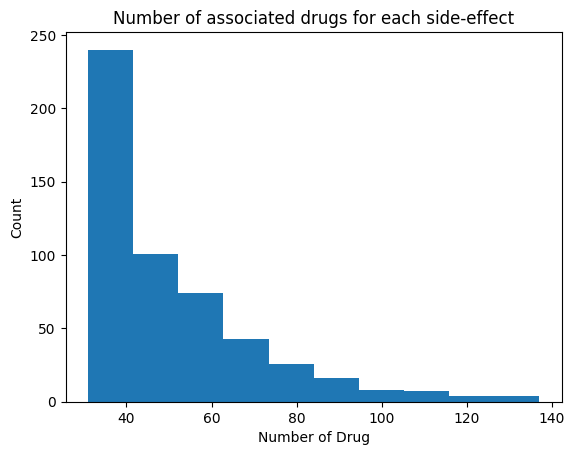

In [10]:
ax = filtered_df_ds.groupby('Individual Side Effect').count()['STITCH'].hist(grid=False)#, figsize=(8*1.1, 6*1.1))
ax.set_xlabel("Number of Drug")
ax.set_ylabel("Count")
ax.set_title("Number of associated drugs for each side-effect")


Text(0.5, 1.0, 'Number of associated side effects for each drug')

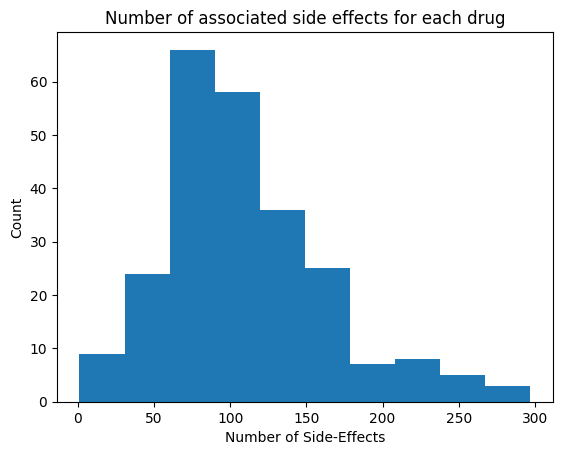

In [11]:
ax = filtered_df_ds.groupby('STITCH').count()['Individual Side Effect'].hist(grid=False)
ax.set_xlabel("Number of Side-Effects")
ax.set_ylabel("Count")
ax.set_title("Number of associated side effects for each drug")


## Visualize Network

In [12]:
import pickle

with open('../data/sample_networks/rw_1.pickle', 'rb') as f:
    rw = pickle.load(f)

In [13]:
rw.M # transition matrix

array([[0.        , 0.00140672, 0.00088377, ..., 0.        , 0.        ,
        0.        ],
       [0.00119481, 0.        , 0.00083329, ..., 0.00364964, 0.00364964,
        0.        ],
       [0.00087577, 0.0009722 , 0.        , ..., 0.        , 0.0125    ,
        0.        ],
       ...,
       [0.        , 0.00568182, 0.        , ..., 0.        , 0.00390844,
        0.00170813],
       [0.        , 0.00215517, 0.00215517, ..., 0.00375824, 0.        ,
        0.00153661],
       [0.        , 0.        , 0.        , ..., 0.00381859, 0.00357243,
        0.        ]], dtype=float32)

## Side-Effects Network

transition prob. based on # of shared drugs

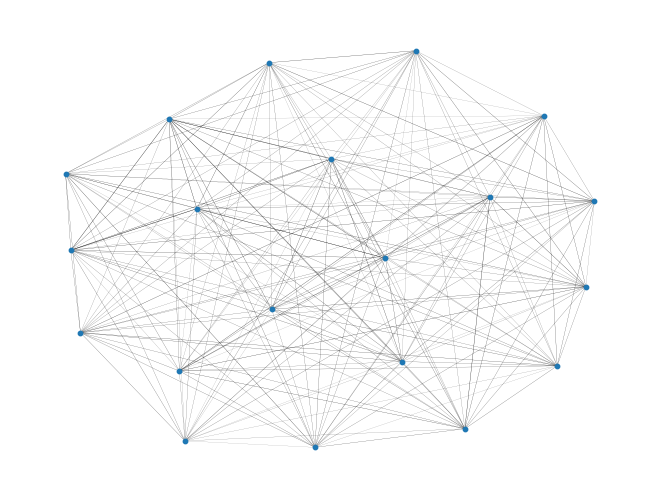

In [14]:
import networkx as nx
G = nx.from_numpy_matrix(rw.M_ss[:20, :20])
edges = G.edges()
weights = [rw.M_ss[u,v] for u,v in edges]
pos = nx.circular_layout(G)
nx.draw(G, node_size=10, width=np.array(weights)*100)

## Drug-Drug Network

transition prob. based on 1) # of shared protein targets and 2) chemical similarity

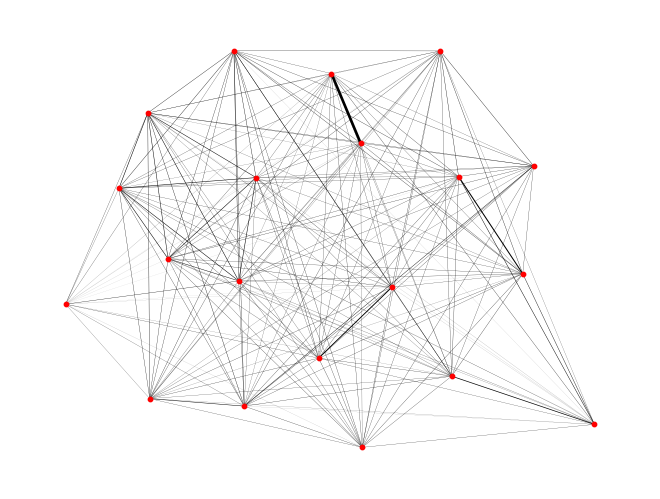

In [15]:
G = nx.from_numpy_matrix(rw.M_dd[:20, :20])
edges = G.edges()
weights = [rw.M_dd[u,v] for u,v in edges]
pos = nx.circular_layout(G)
nx.draw(G, node_color='red', node_size=10, width=np.array(weights)*100)

## Drug (red) - Side Effects (blue) Network

edges connecting all drug - side effects pairs

In [16]:
def visualize_ds(df, n=1000):
    poi = df[['STITCH', 'Individual Side Effect']].head(n)
    Gp = nx.Graph()
    Gp.add_edges_from(list(poi.itertuples(index=False, name=None)))
    nx.draw(Gp, node_size=[6 if node.startswith('CID') else 2 for node in Gp.nodes], 
            node_color= ['red' if node.startswith('CID') else 'blue' for node in Gp.nodes], width=0.1)

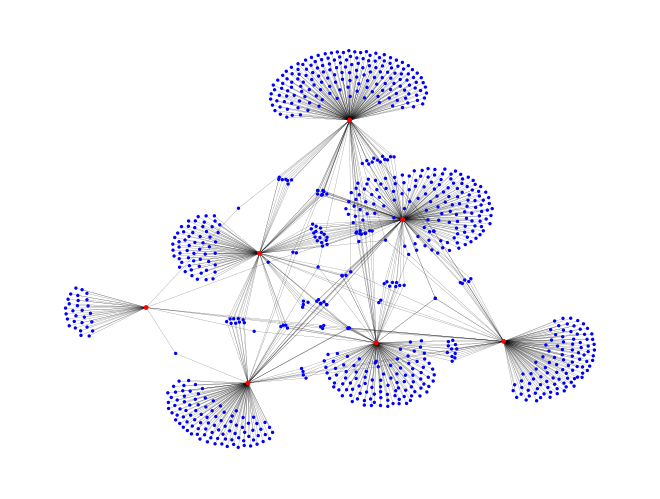

In [17]:
visualize_ds(df_ds, n=1000)

$$p_{k} = \alpha p_0 + (1-\alpha) M^T p_{k-1}$$

In [18]:
import os

df = filtered_df_ds
d = "../data/sample_networks"

def walk(rw, seeds, se_seeds, restart_prob=0.2, nu=0.5, max_iter=100):
    """
    rw (RandomWalk instance)
    seeds (list[int]): list of drug index to predict side-effects
    nu: weight of side effect seeds (start nodes) where 1-nu will be weight of drug seeds
    """
    Mt = rw.M.T
    p0 = np.zeros(Mt.shape[0])
    
    for s in seeds:
        p0[s] = 1/len(seeds)*(1-nu)
    
    for s in se_seeds:
        p0[s] = 1/len(se_seeds)*nu
        
    p = (1-restart_prob)*np.matmul(Mt, p0)+restart_prob*p0
    
    for i in range(max_iter): # actually converges very fast
        p_old = p.copy()
        p = (1-restart_prob)*np.matmul(Mt, p) + restart_prob*p0
        diff = np.abs(p - p_old)
        if np.max(diff) < 1e-8:
            break  
        
    return p


def rank_cutoff(path, known_se=True, restart_prob=0.2):
    
    with open(f"{path}/rw_1.pickle", 'rb') as f: # read one for len reference
        rw = pickle.load(f)
    df = filtered_df_ds
    ys = np.zeros(len(rw.all_se))
    n = 0
    y_true = []
    scores = []
    for filename in tqdm(os.listdir(d)):
        if not filename.endswith("pickle"):
            continue


        with open(os.path.join(path, filename), 'rb') as f:
            rw = pickle.load(f)
        

        poi = df[df.STITCH.isin(rw.all_drugs)&(df[se_label].isin(rw.all_se))]
        mp = list(rw.p_mapping)
        for test_drug in rw.test_drugs:
            if known_se:
                p = walk(rw, [mp.index(test_drug)], se_seeds=[mp.index(se) for se in rw.known_se], 
                         nu=0.5, restart_prob=restart_prob)
                y = set(poi[poi.STITCH==test_drug][se_label].unique()).difference(set(rw.known_se))
            else:
                p = walk(rw, [mp.index(test_drug)], se_seeds=[], nu=0,
                         restart_prob=restart_prob)
                y = set(poi[poi.STITCH==test_drug][se_label].unique())
                
            y = set(poi[poi.STITCH==test_drug][se_label].unique())
            n += len(y)
            idx = np.argsort(-p[:len(rw.all_se)])
            top_ranked = [rw.p_mapping[i] for i in idx]
            
            # ROC curve
            known_se = rw.known_se if known_se else []
            y_true += [int(rw.p_mapping[i] in y) for i in range(len(rw.all_se)) if (rw.p_mapping[i] not in known_se)]
            scores += [p[i] for i in range(len(rw.all_se)) if rw.p_mapping[i] not in known_se]
            pred = np.array([len(y.intersection(set(top_ranked[:i]))) for i in range(len(rw.all_se))])
            ys += pred

    xs = np.arange(len(rw.all_se))
    ys = ys/n
    return xs, ys, y_true, scores



In [19]:
PATH = "../data/sample_networks"

In [22]:
with open('../data/sample_networks/rw_1.pickle', 'rb') as f:
    rw = pickle.load(f)

# test random walk
mp = list(rw.p_mapping)
test_drug_idx = mp.index(rw.test_drugs[0])
p = walk(rw, seeds=[2], se_seeds=[]) # stationary state probability
p[:10] 

array([0.00038719, 0.00068298, 0.10036724, 0.00034884, 0.00031073,
       0.00038536, 0.00036796, 0.00057292, 0.00044055, 0.00042508])

## Run with different restart prob

In [23]:
y_trues = []
scores = []
for r in np.linspace(0.1,0.9, 9):
    xs, ys, y_true, score = rank_cutoff(PATH, known_se=False, restart_prob=r)
    y_trues.append(y_true)
    scores.append(score)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:05<00:00, 17.82it/s]


In [22]:
from sklearn import metrics
for yt, sc in zip(y_trues, scores):
    auc = metrics.roc_auc_score(yt, sc)
    print(auc)

0.616219369945358
0.6209173864698505
0.6237136676467476
0.6254330981818266
0.6264700362510731
0.6270811727014698
0.6274187946372171
0.6275975444405989
0.6276674560670159


## Run at default restart prob 0.2

In [25]:
xs, ys, y_true, scores = rank_cutoff("../data/sample_networks", known_se=False)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:07<00:00, 12.27it/s]


In [27]:
xs, ys_se, y_true_se, scores_se = rank_cutoff("../data/sample_networks_se_seeds", known_se=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:10<00:00,  9.37it/s]


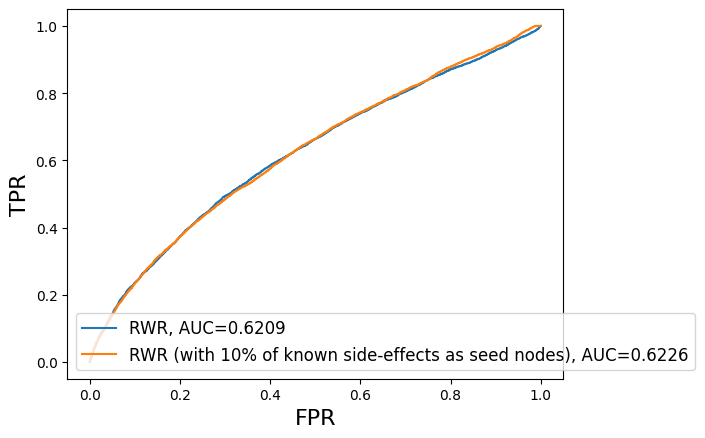

In [28]:
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(y_true, scores)
fpr_se, tpr_se, thresholds = metrics.roc_curve(y_true_se, scores_se)
auc = metrics.roc_auc_score(y_true, scores)
auc_se = metrics.roc_auc_score(y_true_se, scores_se)
# print(auc, auc_se)
plt.plot(fpr, tpr, label='RWR, AUC={:.4f}'.format(auc))
plt.plot(fpr_se, tpr_se, label='RWR (with 10% of known side-effects as seed nodes), AUC={:.4f}'.format(auc_se))

plt.xlabel('FPR', fontsize=16)
plt.ylabel('TPR', fontsize=16)

plt.legend(fontsize=12)

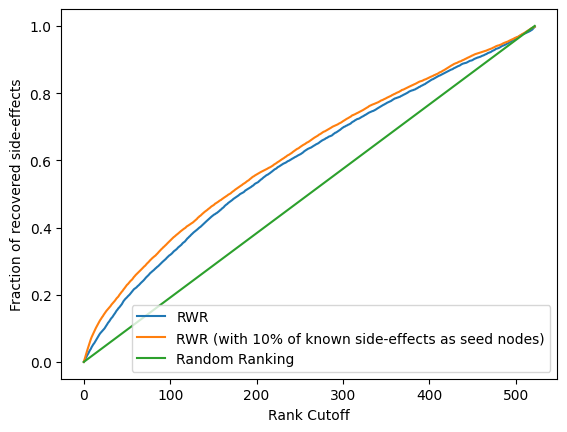

In [29]:
plt.plot(xs, ys, '-', label='RWR') #()/()
plt.plot(xs, ys_se, '-', label='RWR (with 10% of known side-effects as seed nodes)') #()/()

plt.plot(np.arange(len(rw.all_se)), np.linspace(0,1, len(rw.all_se)), '-', label='Random Ranking')
plt.xlabel('Rank Cutoff')
plt.ylabel('Fraction of recovered side-effects')
plt.legend()